## Visualization Ideas

- In TPR Block, plot attention map of filler vector for each role vector
    - Have to get outputs of fr and ff
- In TPR Inference Head, plot attention???

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchmetrics
import torchvision

from einops import rearrange
from PIL import Image
from sklearn.manifold import TSNE
from torch import nn
from transformers import ViTModel

from models.tpr_block_vit_hf import TPViT
from models.tpr_block_vit_lightning import PLModel

In [12]:
encoder_depth = 12
n_heads = 4
tpr_att_head_dim = 768 / n_heads
inference_head_dim = 96

In [3]:
model = PLModel.load_from_checkpoint(r'wandb\1felrfsi\checkpoints\epoch=25-step=36305.ckpt')
model.eval;

hf_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [4]:
# Register forward hooks

activation = {}

def get_activation(name):
    def hook(module, module_in, module_out):
        activation[name] = module_out.detach().numpy()
    return hook

# encoder activations
for i in range(encoder_depth):  # encoder depth
    model.model.vit.encoder.layer[i].attention.attention.query.register_forward_hook(get_activation(f'encoder_q{i}'))
    model.model.vit.encoder.layer[i].attention.attention.key.register_forward_hook(get_activation(f'encoder_k{i}'))
    model.model.vit.encoder.layer[i].attention.attention.value.register_forward_hook(get_activation(f'encoder_v{i}'))

# tpr block
model.model.tpr_block.role.register_forward_hook(get_activation('r'))
model.model.tpr_block.filler.to_qkv.register_forward_hook(get_activation('f'))

# tpr inference block
model.model.tpr_inference_block.layers[0][0].fn.to_q.register_forward_hook(get_activation('inference_q'))
model.model.tpr_inference_block.layers[0][0].fn.to_kv.register_forward_hook(get_activation('inference_kv'))

In [5]:
# Set up synset to class label conversion
label_dict = {}

with open('synset_to_class.txt') as f:
    for line in f:
        key, value = line.strip().split(':')
        key = int(key)
        label_dict[key] = value

In [6]:
# returns logits + r or f vector for tpr block
def get_vector(image, activation, vector='f'):
    assert vector in ['r', 'f'], "vector must be r or f"
    
    logits = model(image)
    if vector == 'r':
        v = torch.Tensor(activation['r'])  # b, d, r
        v = torch.squeeze(v, dim=0)  # d, r
        v = rearrange(v, 'd r -> r d')
        
    elif vector == 'f':
        vec = torch.Tensor(activation['f'])  # b, n, d
        vec = vec.chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=n_heads), vec)

        dots = torch.matmul(q, k.transpose(-1, -2)) * (64 ** -0.5)

        att = nn.functional.softmax(dots, dim=-1)
        v = att
        
    return logits, v


# returns encoder attentions for all layers
def get_att(image, activation, block="encoder"):
    assert block in ["encoder", "tpr"], "block should be encoder or tpr"
    
    logits = model(image)
    
    if block == "encoder":
        q = []
        k = []
        v = []
        for i in range(encoder_depth):
            q.append(torch.Tensor(activation[f'encoder_q{i}']))
            k.append(torch.Tensor(activation[f'encoder_k{i}']))
            v.append(torch.Tensor(activation[f'encoder_v{i}']))
        qs = tuple(q)
        ks = tuple(k)
        vs = tuple(v)

        atts = []
        for i in range(12):
            q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = n_heads), (qs[i], ks[i], vs[i]))

            dots = torch.matmul(q, k.transpose(-1, -2)) * (tpr_att_head_dim ** -0.5)

            att = nn.functional.softmax(dots, dim=-1)
            atts.append(att)
        atts = tuple(atts)
        
    elif block == "tpr":
        q = torch.Tensor(activation["inference_q"])
        kv = torch.Tensor(activation["inference_kv"])
        kv = kv.chunk(2, dim=-1)
        q = rearrange(q, 'b n h d -> b h n d', h=n_heads)
        k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=n_heads), kv)
        
        dots = torch.matmul(q, k.transpose(-1, -2)) * (inference_head_dim ** -0.5)
        att = nn.functional.softmax(dots, dim=-1)
        atts = att
        
    return logits, atts

In [7]:
# Multi-head mask and plot

# returns attention mask for every head
def get_head_att(img, att_mat, get_mask=False):
    #att_mat = torch.unsqueeze(att_mat, dim=0)
    # att_mat = torch.stack(att_mat).squeeze(1)  # Out: depth, h, d, d
    att_mat = rearrange(att_mat, 'depth h d1 d2 -> h depth d1 d2')
    
    masks = []
    for i in range(n_heads):
        att_mat_h = att_mat[i]
        # To account for residual connections, we add an identity matrix to the
        # attention matrix and re-normalize the weights.
        residual_att = torch.eye(att_mat_h.size(1))
        aug_att_mat = att_mat_h + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

        # Recursively multiply the weight matrices
        joint_attentions = torch.zeros(aug_att_mat.size())  # depth, d, d
        joint_attentions[0] = aug_att_mat[0]

        for n in range(1, aug_att_mat.size(0)):
            joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
            
        v = joint_attentions[-1]
        grid_size = int(np.sqrt(aug_att_mat.size(-1)))
        mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
        masks.append(mask)
        
    if get_mask:
        results = []
        for i in range(len(masks)):
            result = cv2.resize(masks[i] / masks[i].max(), img.size)
            results.append(result)
    else:
        results = []
        for i in range(len(masks)):
            mask = cv2.resize(masks[i] / masks[i].max(), img.size)[..., np.newaxis]
            result = (mask * img).astype("uint8")
            results.append(result)
    return results


# plots attention masks for each head
def plot_head_maps(image, logits, att_maps):
    pred = logits.argmax(axis=1).item()
    label = label_dict[pred]
    print(f"Predicted class: {label}")
    
    # Plot input image.
    image = torch.squeeze(image)
    image = image.detach().numpy()
    image = np.transpose(image, (1, 2, 0))
    fig = plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    
    plt.figure(figsize=(15,12))
    for i in range(n_heads):
        ax = plt.subplot(int(n_heads/4), 4, i+1)
        plt.imshow(att_maps[i])
        # ax.set_title(f'Head {i+1}')
        ax.set_xticks([])
        ax.set_yticks([])
        

In [8]:
# Heads-averaged mask and plot

# returns attention mask averaged across all heads
def get_attention_map(img, att_mat, get_mask=False):
    att_mat = torch.stack(att_mat).squeeze(1)  # Out: depth, h, d, d

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)  # Out: depth, d, d

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())  # depth, d, d
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

# plots attention mask for averaged heads
def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)


## Image

In [9]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])


image_path = r'B:\PhD\Projects\tp-vit\test_images\street-7c.JPG'
plot_image = Image.open(image_path)
image = Image.open(image_path)
image = transform(image)
image = torch.unsqueeze(image, dim=0)

logits, v = get_vector(image, activation, 'f')

## TPR Block (Role)

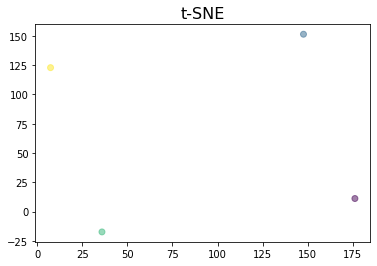

In [13]:
def plot_role(image, v):
    z_emb = TSNE(n_components=2).fit_transform(v)
    
    colors = np.arange(n_heads)

    x = z_emb[:, 0]
    y = z_emb[:, 1]

    plt.scatter(x, y, c=colors, alpha=0.5)
    plt.title("t-SNE", fontsize=16);
    

_, r = get_vector(image, activation, 'r')
plot_role(image, r)

## TPR Block (Filler)

Predicted class:  'velvet',


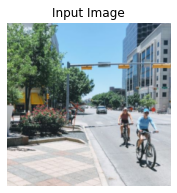

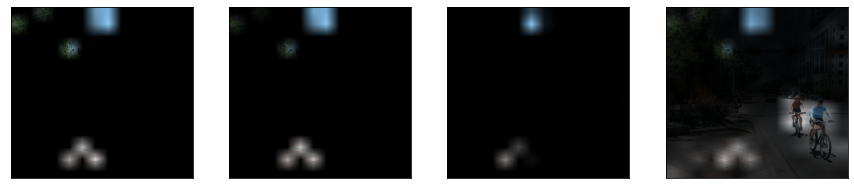

In [14]:
att_maps = get_head_att(plot_image, v)
plot_head_maps(image, logits, att_maps)

## Inference Head Attention

Predicted class:  'velvet',


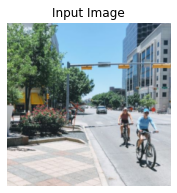

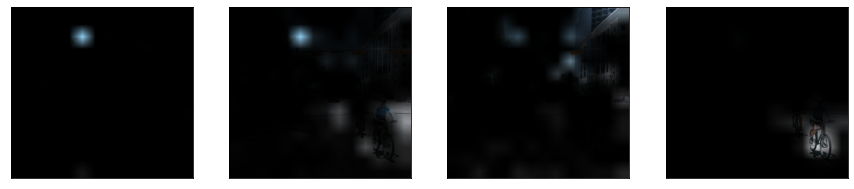

In [15]:
logits, inference_att = get_att(image, activation, block="tpr")

att_maps = get_head_att(plot_image, inference_att)
plot_head_maps(image, logits, att_maps)

## Encoder Attention

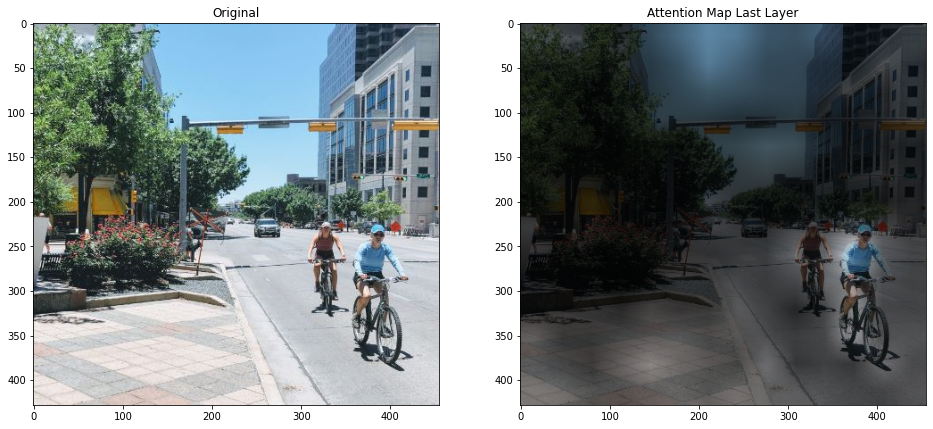

In [16]:
logits, encoder_att = get_att(image, activation, block="encoder")

att_map = get_attention_map(plot_image, encoder_att)
plot_attention_map(plot_image, att_map)

Predicted class:  'velvet',


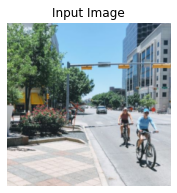

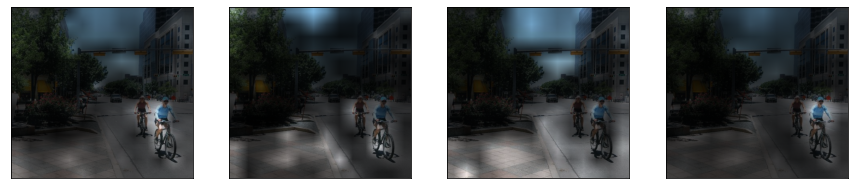

In [17]:
encoder_att = torch.stack(encoder_att).squeeze(1)
att_maps = get_head_att(plot_image, encoder_att)
plot_head_maps(image, logits, att_maps)

## Vanilla HF Model for Sanity Check

In [ ]:
with torch.no_grad():
    att = hf_model(image, output_attentions=True).attentions
att_map = get_attention_map(plot_image, att)
plot_attention_map(plot_image, att_map)

In [ ]:
print(model)

In [ ]:
print(hf_model)